# July 4, 2022: Compute Intersubject Correlation (ISC) values for `early` and `late` periods in `threat` and `safe` conditions

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import norm, zscore

# ISC
from brainiak.isc import (isc, isfc, bootstrap_isc, compute_summary_statistic)
from statsmodels.stats.multitest import multipletests

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils as dataset_utils

In [2]:
'''
exploratory data
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.NAMES = ['safe', 'threat']
args.MASK = -100

num_rois = 85
args.roi_idxs = np.arange(num_rois)

with open(f"{proj_dir}/data/max/exploratory_data.pkl", 'rb') as f:
    X = pickle.load(f)

In [3]:
'''
find minimum number of trials across subjects
'''
min_trials = []
for label in args.LABELS:
    min_trials += [x.shape[0] for x in X[label]]
min_trials = min(min_trials)

ts = {}
for label, name in zip(args.LABELS, args.NAMES):
    ts[name] = []
    for x in X[label]:
        trl, t, r = x.shape
        x = np.reshape(x[:min_trials, ...], (min_trials*t, r))
        ts[name].append(zscore(x, axis=0))

## Following the pipeline in ISC tutorial
Paper: https://academic.oup.com/scan/article/14/6/667/5489905
Tutorial: https://github.com/snastase/isc-tutorial

Statistical significance was assessed by a nonparametric bootstrap hypothesis test resampling left-out subjects and corrected for multiple tests by controlling FDR at .05.

i.e.:
1. Compute leave-one-out (LOO) ISC values
2. Bootstrap hypothesis testing, (Chen et al.2016)
3. Multiple tests correction: False Discovery Rate (FDR) at 0.05.

LOO method relates to computing ISFC values, as the mean time series of the remaining subjects converges to the common signal across subjects.

## `early` and `late` periods 

In [4]:
def get_isc_significant_rois(args, ts):
    iscs = {}
    bootstraps = {}
    q = {}
    z = {}
    rois = {}
    for block, block_ts in ts.items():
        iscs[block] = isc(
            block_ts, 
            pairwise=args.pairwise, 
            summary_statistic=None
        )

        # permutation test
        bootstraps[block] = bootstrap_isc(
            iscs[block], pairwise=args.pairwise, 
            ci_percentile=95, 
            summary_statistic='median',
            n_bootstraps=args.n_bootstraps
        )

        # multiple tests correction
        q[block] = multipletests(bootstraps[block][2], method='fdr_by')[1]
        z[block] = np.abs(norm.ppf(q[block]))

        # surviving rois
        rois[block] = q[block][np.newaxis, :] < 0.05
        # rois[name] = bootstraps[name][2][np.newaxis, :] < 0.05
        print(f"number of significant rois for condition {block} = {np.sum(rois[block])}")
    
    return iscs, bootstraps, q, z, rois

In [5]:
def plot_iscs(args, iscs, rois):
    nrows, ncols = len(args.LABELS), len(args.PERIODS)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(10*ncols, 4*nrows), 
        sharex=True, 
        sharey=True, 
        dpi=120
    )

    for label, name in zip(args.LABELS, args.NAMES):
        for idx_period, period in enumerate(args.PERIODS):
            ax = axs[label, idx_period]
            block = f"{name}_{period}"

            mn = np.mean(iscs[block], axis=0)
            st = np.std(iscs[block], axis=0) / np.sqrt(len(iscs[block]))
            ax.plot(mn, label='mean')
            ax.fill_between(
                np.arange(st.shape[0]),
                (mn - st), (mn + st),
                label='ste',
                alpha=0.3
            )

            for r in np.where(rois[block])[1]:
                ax.axvline(r, color='purple', alpha=0.3)
            
            ax.legend()
            ax.set_title(block)
            ax.set_ylabel(f"isc")
            ax.set_xlabel(f"rois")
    
    return None

In [6]:
'''
time series of early and late periods
'''
args.PERIODS = ['early', 'late']
# time periods
args.TR = 1.25 #seconds
EARLY = np.arange(2.5, 8.75+args.TR, args.TR) // args.TR
LATE = np.arange(10.0, 16.25+args.TR, args.TR) // args.TR
EARLY = EARLY.astype(int)
LATE = LATE.astype(int)
args.PERIOD_TRS = [EARLY, LATE]

ts = {}
for label, name in zip(args.LABELS, args.NAMES):
    for idx_period, (period, TRs) in enumerate(zip(args.PERIODS, args.PERIOD_TRS)):
        ts[f"{name}_{period}"] = []
        for x in X[label]:
            x = x[:, args.PERIOD_TRS[idx_period], :]
            trl, t, r = x.shape
            x = np.reshape(x[:min_trials, ...], (min_trials*t, r))
            ts[f"{name}_{period}"] += [zscore(x, axis=0)]

number of significant rois for condition safe_early = 0
number of significant rois for condition safe_late = 0
number of significant rois for condition threat_early = 13
number of significant rois for condition threat_late = 19


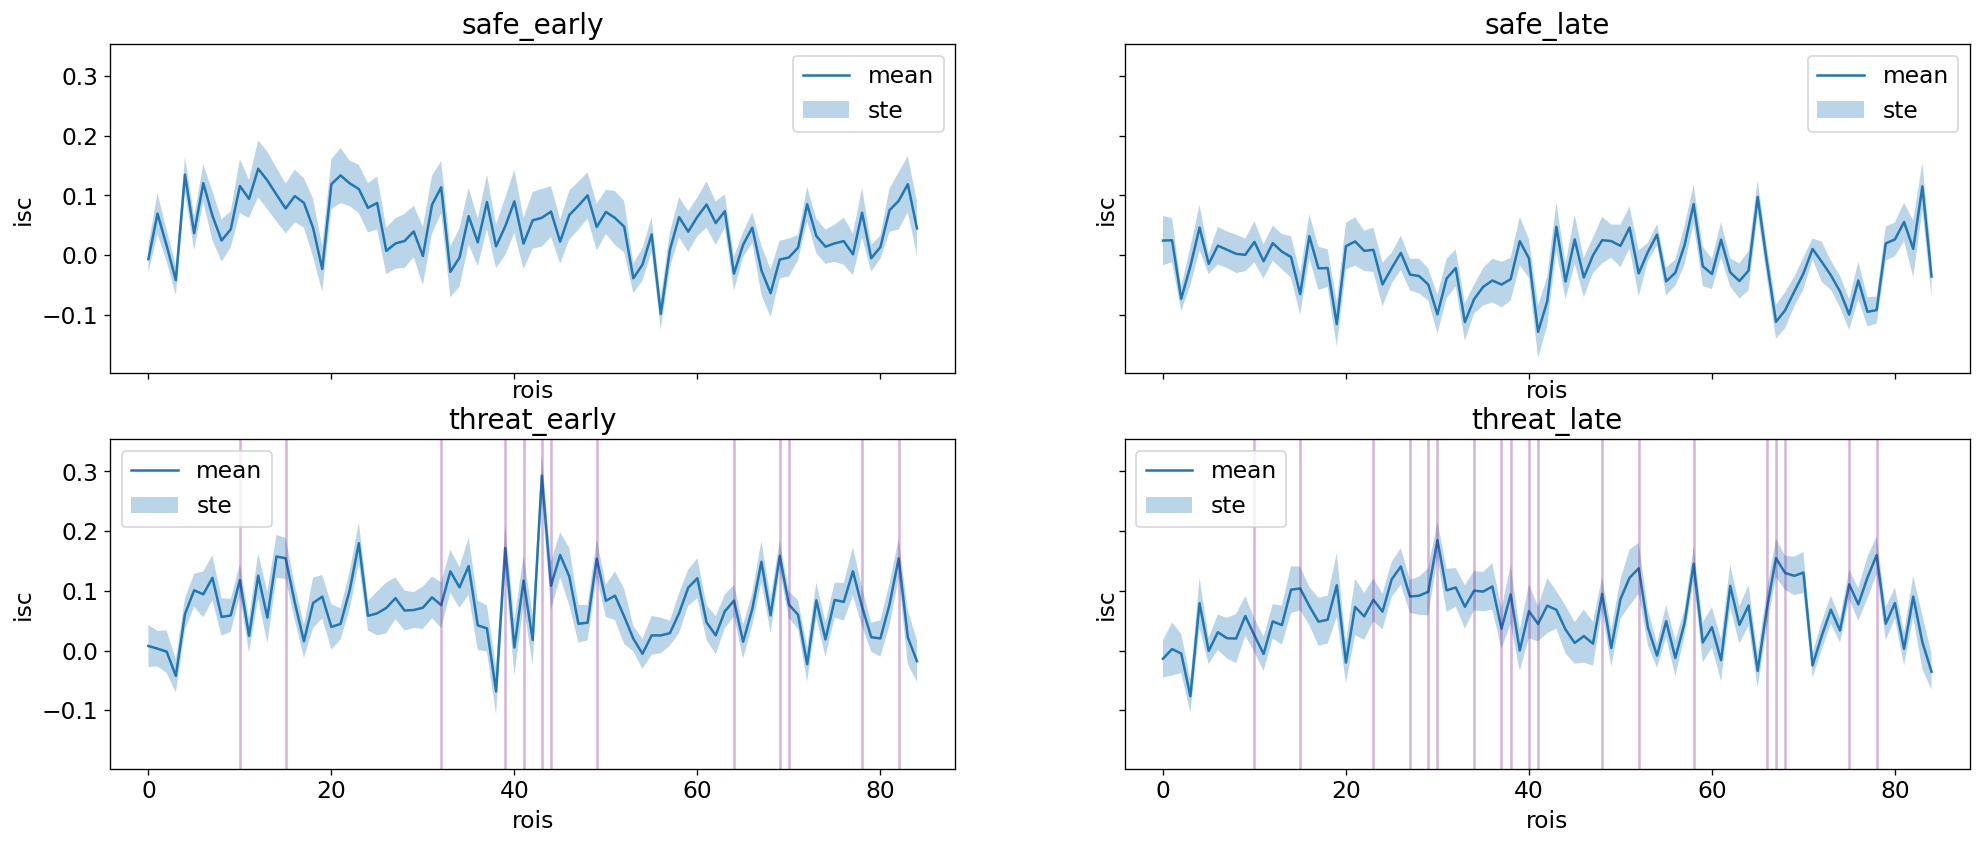

In [7]:
'''
ISC
leave-one-out
bootstrap
'''
args.pairwise = False
args.n_bootstraps = 1000
iscs, bootstraps, q, z, rois = get_isc_significant_rois(args, ts)
plot_iscs(args, iscs, rois)